# Compute the power spectrum for each file

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import pandas as pd
from joblib import Memory
import re
%matplotlib inline

## Make a dataframe of file meta data

In [88]:
def pathToSeries(path):
    if 'train' in path: train = 1
    else: train = 0
    if train: 
        m = re.search('(\d).mat',path)
        preictal = int(m.group(1))
    else: preictal = -1
    m = re.search('(\d)/',path)
    patient = int(m.group(1))
    m = re.search('(.*)/(.*)',path)
    dir_name = m.group(1)
    file_name = m.group(2)
    return pd.Series({'path':path,'train':train,'preictal':preictal, 'patient':patient,
                     'dir_name': dir_name,'file_name':file_name})

base_data_dir = '../raw_data'
data_dirs = [name for name in os.listdir(base_data_dir) if os.path.isdir(os.path.join(base_data_dir, name))]
paths = [[os.path.join(data_dir, name) for name in os.listdir(os.path.join(base_data_dir,data_dir))] 
         for data_dir in data_dirs] 
paths = [j for i in paths for j in i] # flatten to 1d
paths = [i for i in paths if '.DS_Store' not in i]
    
files_df = pd.DataFrame([pathToSeries(p) for p in paths])
files_df.head(5)

,dir_name,file_name,path,patient,preictal,train
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0


## Accessing the data

In [73]:
def matToArr(path):
    try: 
        mat = loadmat(path)
        return mat['dataStruct']['data'][0][0].transpose()
    except:
        return np.empty(0)

## Compute power spectrum for each file and save

In [76]:
mem = Memory(cachedir='../cache', verbose=0)

@mem.cache
def extract_pib_features(path,bins):
    samples = matToArr(path)
    if samples.size == 0: return np.array([-1]*(len(bins)-2)) # handles corrupt file
    freq_data = np.abs(np.fft.fft(samples))
    max_power = np.max(freq_data)
    if max_power == 0: max_power = 1 # avoids divide by zero error if all data missing
    pib, _ = np.histogram(freq_data/max_power, bins=bins)
    return pib[:-1]

bins = np.array([0, .001, .005, .01, 1])
pibs = []
for ind, row in files_df.iterrows():
    print(str(ind) + " ",end="")
    pib = extract_pib_features(os.path.join(base_data_dir,row['path']),bins)
    pibs.append(pib)
pibs = np.array(pibs)
pibs_df = pd.DataFrame(pibs,columns={'pib_1','pib_2','pib_3'})
files_df = pd.concat([files_df, pibs_df],axis=1)
files_df.to_pickle('../processed_data/files_df.pkl')
files_df.head()

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

## Read in saved data to make sure saved correctly.

In [90]:
files_df = pd.read_pickle('../processed_data/files_df.pkl')
files_df.head()

,dir_name,file_name,path,patient,preictal,train,pib_3,pib_2,pib_1
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0,848777,1897922,511194
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0,1805838,1484367,216014
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0,1241170,1900609,284337
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0,1743604,1513067,231791
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0,2139217,1235885,187611


## Visualize results

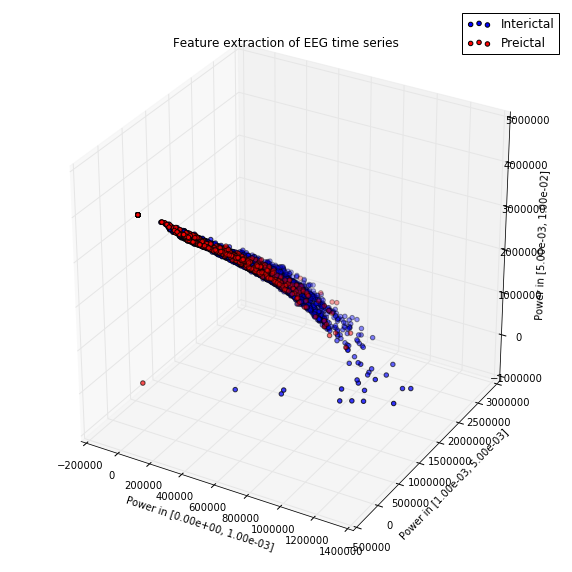

In [99]:
interictal_features = files_df[files_df['preictal']==0]
preictal_features = files_df[files_df['preictal']==1]

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.scatter(interictal_features['pib_1'],
           interictal_features['pib_2'],
           interictal_features['pib_3'], c='blue', label='Interictal')
ax.scatter(preictal_features['pib_1'],
           preictal_features['pib_2'],
           preictal_features['pib_3'], c='red', label='Preictal')
ax.set_xlabel('Power in [%.2e, %.2e]' % (bins[0], bins[1]))
ax.set_ylabel('Power in [%.2e, %.2e]' % (bins[1], bins[2]))
ax.set_zlabel('Power in [%.2e, %.2e]' % (bins[2], bins[3]))
ax.set_title('Feature extraction of EEG time series')
ax.legend()
plt.show()